In [3]:
# import tensorflow as tf

# class DifferentiableCropLayer(tf.keras.layers.Layer):
#     def __init__(self, target_size=(15, 15)):
#         super(DifferentiableCropLayer, self).__init__()
#         self.target_size = target_size
    
#     def call(self, images):
#         # Assuming the input images are grayscale and normalized [0, 1]
#         def crop_and_resize(image):
#             # Create a mask where the pixels are non-zero
#             mask = tf.cast(image > 0.1, tf.float32)
            
#             # Calculate the bounding box
#             x_proj = tf.reduce_sum(mask, axis=0)
#             y_proj = tf.reduce_sum(mask, axis=1)
            
#             x_nonzero = tf.where(x_proj > 0)
#             y_nonzero = tf.where(y_proj > 0)
            
#             x_min = tf.reduce_min(x_nonzero)
#             x_max = tf.reduce_max(x_nonzero)
#             y_min = tf.reduce_min(y_nonzero)
#             y_max = tf.reduce_max(y_nonzero)
            
#             # Crop the image using the bounding box, considering tensor shape
#             cropped_image = tf.image.crop_to_bounding_box(image,
#                                                           offset_height=y_min,
#                                                           offset_width=x_min,
#                                                           target_height=y_max - y_min + 1,
#                                                           target_width=x_max - x_min + 1)
#             # Resize to target size
#             resized_image = tf.image.resize(cropped_image, self.target_size, method='bilinear')
#             return resized_image
        
#         # Apply the crop_and_resize to each image in the batch
#         cropped_resized_images = tf.map_fn(crop_and_resize, images, dtype=tf.float32)
#         return cropped_resized_images


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

2024-08-01 17:53:09.327259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 17:53:09.340831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 17:53:09.347252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-01 17:53:09.368929: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 17:53:10.299678: W tensorflow/compiler/tf2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # This disables GPU usage in TensorFlow

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  # Memory growth must be set before GPUs have been initialized


2024-08-01 17:53:13.162915: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-01 17:53:13.162980: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: shenron.urcf.drexel.edu
2024-08-01 17:53:13.162988: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: shenron.urcf.drexel.edu
2024-08-01 17:53:13.163122: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 550.90.7
2024-08-01 17:53:13.163170: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 550.90.7
2024-08-01 17:53:13.163175: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 550.90.7


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [5]:
def create_dataset():
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # Normalizing and resizing MNIST digits to be placed in a 256x256 image
    def place_digit(image):
        size = 256
        placement = np.zeros((size, size), dtype=np.float32)
        x_offset = np.random.randint(0, size - 28)
        y_offset = np.random.randint(0, size - 28)
        placement[y_offset:y_offset+28, x_offset:x_offset+28] = image
        return placement, [x_offset / size, y_offset / size, (x_offset + 28) / size, (y_offset + 28) / size]

    # Applying the function and separating results
    train_results = [place_digit(img) for img in train_images]
    test_results = [place_digit(img) for img in test_images]

    # Normalize and reshape images
    train_images = np.array([res[0] for res in train_results]) / 255.0
    train_bboxes = np.array([res[1] for res in train_results])
    test_images = np.array([res[0] for res in test_results]) / 255.0
    test_bboxes = np.array([res[1] for res in test_results])

    # Expand dimensions to include channel information
    train_images = np.expand_dims(train_images, axis=-1)
    test_images = np.expand_dims(test_images, axis=-1)

    return (train_images, train_bboxes, train_labels), (test_images, test_bboxes, test_labels)

(train_images, train_bboxes, train_labels), (test_images, test_bboxes, test_labels) = create_dataset()


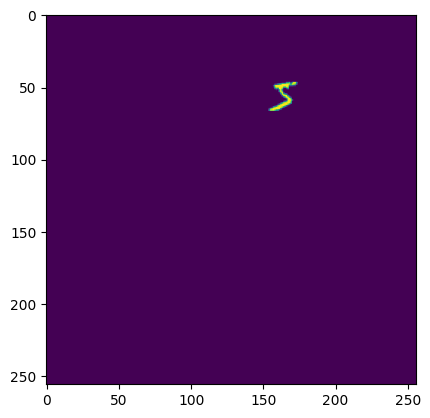

In [6]:
plt.imshow(train_images[0])

In [36]:
class CropLayer(tf.keras.layers.Layer):
    def __init__(self, target_size=(28, 28), padding_mode='CONSTANT'):
        super().__init__()
        self.target_size = target_size
        self.padding_mode = padding_mode

    def build(self, input_shape):
        # This function can help manage dimensions better and is a good place to initialize weights if needed
        super().build(input_shape)

    def call(self, inputs):
        images, coords = inputs
        shape = tf.cast(tf.shape(images), tf.float32)
        center_x, center_y, width, height = tf.split(coords, 4, axis=1)
        half_width = width * shape[2] / 2
        half_height = height * shape[1] / 2

        x_min = tf.cast(center_x * shape[2] - half_width, tf.int32)
        y_min = tf.cast(center_y * shape[1] - half_height, tf.int32)
        x_max = tf.cast(center_x * shape[2] + half_width, tf.int32)
        y_max = tf.cast(center_y * shape[1] + half_height, tf.int32)

        crop_height = tf.maximum(y_max - y_min, 1)
        crop_width = tf.maximum(x_max - x_min, 1)

        cropped_images = tf.image.crop_to_bounding_box(images, y_min[0], x_min[0], crop_height[0], crop_width[0])
        pad_height = tf.maximum(self.target_size[0] - crop_height, 0)
        pad_width = tf.maximum(self.target_size[1] - crop_width, 0)
        
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        padded_images = tf.pad(cropped_images, [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], mode=self.padding_mode)
        return padded_images

    def compute_output_shape(self, input_shape):
        # Ensure the output shape is correctly defined based on the target size, assuming the last dimension remains unchanged
        return (input_shape[0][0], *self.target_size, input_shape[0][-1])



# Usage Example
# Assuming 'model_input' and 'bbox_coords' are your input images and bounding box coordinates
# crop_layer = CropLayer(target_size=(28, 28))
# cropped_and_padded_images = crop_layer([model_input, bbox_coords])



def create_model():
    input_layer = Input(shape=(256, 256, 1))
    
    # Base convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    
    # Localization branch predicts coordinates for cropping
    localization = Dense(128, activation='relu')(x)
    coords = Dense(4, activation='sigmoid', name='localization_output')(localization)  # Named output for localization
    
    # Cropping layer
    crop_layer = CropLayer()(inputs=[input_layer, coords])
    
    # Classification branch
    classification_input = Flatten()(crop_layer)
    classification = Dense(128, activation='relu')(classification_input)
    classification = Dropout(0.5)(classification)
    classification_output = Dense(10, activation='softmax', name='classification_output')(classification)  # Named output for classification
    
    # Construct the full model
    model = Model(inputs=input_layer, outputs=[coords, classification_output])
    
    return model

model = create_model()



In [37]:
model.compile(
    optimizer='adam',
    loss={
        'localization_output': 'mean_squared_error',  # Corrected to the actual output layer name
        'classification_output': 'sparse_categorical_crossentropy'  # Corrected to the actual output layer name
    },
    loss_weights={
        'localization_output': 1.0,  # Ensure the weight matches the importance of the task
        'classification_output': 1.0  # Ensure the weight matches the importance of the task
    },
    metrics={
        'localization_output': ['mae'],  # Metrics for the localization output
        'classification_output': ['accuracy']  # Metrics for the classification output
    }
)

In [38]:
history = model.fit(
    train_images, 
    {
        'localization_output': train_bboxes, 
        'classification_output': train_labels
    },
    validation_data=(
        test_images, 
        {
            'localization_output': test_bboxes, 
            'classification_output': test_labels
        }
    ),
    epochs=10,
    batch_size=32
)


Epoch 1/10


ValueError: Exception encountered when calling CropLayer.call().

[1mShapes must be equal rank, but are 1 and 0
	From merging shape 2 with other shapes. for '{{node functional_6_1/crop_layer_13_1/crop_to_bounding_box/stack_2}} = Pack[N=4, T=DT_INT32, axis=0](functional_6_1/crop_layer_13_1/crop_to_bounding_box/stack_2/values_0, functional_6_1/crop_layer_13_1/strided_slice_6, functional_6_1/crop_layer_13_1/strided_slice_7, functional_6_1/crop_layer_13_1/crop_to_bounding_box/stack_2/values_3)' with input shapes: [], [1], [1], [].[0m

Arguments received by CropLayer.call():
  • inputs=['tf.Tensor(shape=(32, 256, 256, 1), dtype=float32)', 'tf.Tensor(shape=(32, 4), dtype=float32)']